## Assignment 2

# 2. Dataset description and Overview
The dataset used for this assignment is a sample from [EMNIST handwritten character dataset - ByClass](https://www.nist.gov/itl/products-and-services/emnist-dataset), a collection of 814,255+ 28 by 28 images with character labels. This smaller sample set can be downloaded from the Google Drive link provided in the assignment specification. The dataset consists of 120000 amount images, of which 100,000 is split into a test set, which was further divided into a validation set after pre-processing, and a testing set of 20,000.

In [50]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn
!pip install scipy==1.12
!pip install torch
!pip install torchvision
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user insta

In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
import pickle
import os


train_dict = pickle.load(open('emnist_train.pkl', 'rb'))
test_dict = pickle.load(open('emnist_test.pkl', 'rb'))

# Extract the images and labels from the dictionaries
train_images = train_dict['data']
train_labels = train_dict['labels']
test_images = test_dict['data']
test_labels = test_dict['labels']
print("Testing images shape:", test_images.shape)
print("Training images shape:", train_images.shape)


Testing images shape: (20000, 28, 28)
Training images shape: (100000, 28, 28)


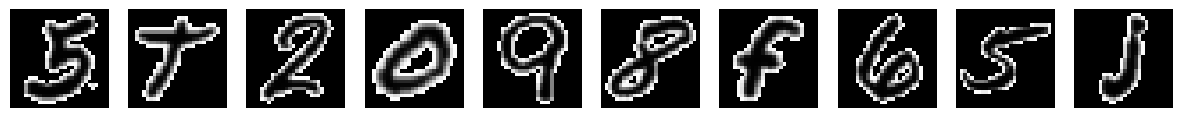

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Number of images to display
num_images = 10

# Create a figure and axes for the grid
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate through the sample images
for i in range(num_images):
    # Select a random image
    random_index = np.random.randint(0, len(train_images))
    image = train_images[random_index].reshape(28, 28)

    # Convert the NumPy array to a PIL image
    pil_image = Image.fromarray((image * 255))  # Convert to uint8 for PIL compatibility

    # Rotate the image 90 degrees clockwise
    rotated_image = pil_image.rotate(-90).transpose(Image.FLIP_LEFT_RIGHT) # Negative angle for clockwise rotation

    # Convert back to NumPy array for displaying with matplotlib
    rotated_image_np = np.array(rotated_image)

    # Display the image
    axes[i].imshow(rotated_image_np, cmap='gray')
    axes[i].axis('off')

plt.show()


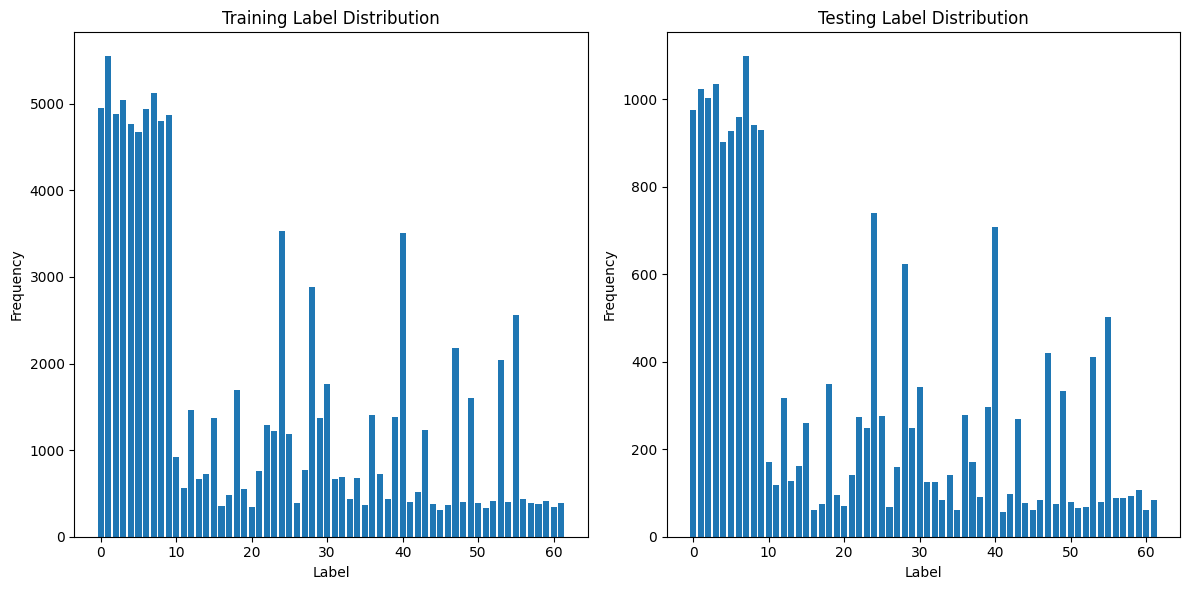

In [59]:
# Calculate the frequency of each label in the training set
train_label_counts = {}
for label in train_labels:
  if label not in train_label_counts:
    train_label_counts[label] = 0
  train_label_counts[label] += 1
# Calculate the frequency of each label in the testing set
test_label_counts = {}
for label in test_labels:
  if label not in test_label_counts:
    test_label_counts[label] = 0
  test_label_counts[label] += 1

def display_data_distribution(train_labels, test_labels):

  # Plot the histogram of training labels
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.bar(train_labels.keys(), train_labels.values())
  plt.title('Training Label Distribution')
  plt.xlabel('Label')
  plt.ylabel('Frequency')

  # Plot the histogram of testing labels
  plt.subplot(1, 2, 2)
  plt.bar(test_labels.keys(), test_labels.values())
  plt.title('Testing Label Distribution')
  plt.xlabel('Label')
  plt.ylabel('Frequency')

  plt.tight_layout()
  plt.show()

display_data_distribution(train_label_counts, test_label_counts)


# 3. Data Preparation

Requred data is provided in a folder that contains a .mat file which is to be loaded in and then XXXX

The folder includes:

Folder details


## 3.1 Loading data

Use the following code to load in the data


In [55]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# Step 1: Normalize the pixel values (0-255) to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Step 2: Reshape the images for model input
N_train = train_images.shape[0]  # Number of training images
N_test = test_images.shape[0]    # Number of testing images

# # Step 3: Data Augmentation
# datagen = ImageDataGenerator(
#     rotation_range=10,       # Randomly rotate images by up to 10 degrees
#     width_shift_range=0.1,   # Randomly shift images horizontally by up to 10% of width
#     height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of height
#     zoom_range=0.1           # Randomly zoom into images by up to 10%
# )

# # Fit the data generator on the training images
# datagen.fit(train_images)

# Step 4: Class Rebalancing
# Compute class weights to account for class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

#Remember Below
# model.fit(train_images, train_labels, class_weight=class_weights_dict)

# Step 5 (Optional): Label Smoothing

# Summary of preprocessing steps
print("Train images shape (after reshaping):", train_images.shape)
print("Test images shape (after reshaping):", test_images.shape)
print("Class weights for balancing:", class_weights_dict)

Train images shape (after reshaping): (100000, 28, 28)
Test images shape (after reshaping): (20000, 28, 28)
Class weights for balancing: {0: 0.32597074086629985, 1: 0.29077036701035724, 2: 0.3301746623964077, 3: 0.31995699777949843, 4: 0.33841863739119843, 5: 0.3452275740167919, 6: 0.3264986287057594, 7: 0.31508170068498764, 8: 0.3360915244439366, 9: 0.3309198247448608, 10: 1.751252145283878, 11: 2.875050313380484, 12: 1.0987079194866836, 13: 2.4290711232024873, 14: 2.218573900696632, 15: 1.1798853151473676, 16: 4.621499214345134, 17: 3.381348481774532, 18: 0.9521270518337968, 19: 2.943254061690605, 20: 4.7023417661995675, 21: 2.1391289466929067, 22: 1.2551776076314798, 23: 1.3231363624335124, 24: 0.4567836946492358, 25: 1.359952129685035, 26: 4.178505766337958, 27: 2.0865500980678546, 28: 0.5604250263399763, 29: 1.1781615966445957, 30: 0.9133087348847404, 31: 2.407318247472316, 32: 2.327421682260392, 33: 3.7509377344336086, 34: 2.3930314922944387, 35: 4.443259575224385, 36: 1.15043026

In [56]:
from torchvision import transforms

# Update data_transforms for training data
data_transforms = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet's mean
                         std=[0.229, 0.224, 0.225])    # ImageNet's std
])

# Update test_transforms without augmentation
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert the tensor to a PIL image for transformations
        image = transforms.ToPILImage()(image)

        # Apply transforms if any
        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets with transforms
train_dataset = CustomDataset(train_images_tensor, train_labels_tensor, transform=data_transforms)
test_dataset = CustomDataset(test_images_tensor, test_labels_tensor, transform=test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [60]:
from torchvision.models import resnet18 
import torch.nn as nn
# Instantiate the model
num_classes = len(np.unique(train_labels))
model = resnet18(num_classes, pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)


/Users/calvin/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/calvin/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for the progress bar

# Assuming train_images, train_labels, test_images, and test_labels are already loaded
# Assuming train_dataset, test_dataset, train_loader, test_loader are already created

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
classes = np.unique(train_labels)
class_weights_list = [class_weights_dict[cls] for cls in classes]
class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float).to(device)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate when using pretrained models

# Training Loop with Progress Bar
num_epochs = 10  # Start with 10 epochs and adjust as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.update(1)
            pbar.set_postfix(loss=running_loss/total, accuracy=100.0 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Accuracy: {100 * correct / total:.2f}%')

# Testing Loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')



Epoch [1/10]:   4%|▍         | 118/3125 [02:53<1:13:41,  1.47s/batch, accuracy=0.794, loss=4.17]


KeyboardInterrupt: 